In [1]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys

from __future__ import division

import threading,time
import multiprocessing

from rtlsdr import RtlSdr, limit_time
import bitarray

%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import util

from radio import *
from encoding import *
from radio_params import *
from radio_transmit import *


In [3]:
name = '../final/createrLake.tiff'

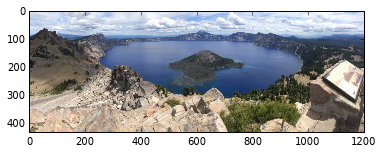

In [ ]:
im = load_image(name)
ims_rgb(im)

In [ ]:
x = compressandencode(name)

Found image with width 1200 and height 432
Downsampling 2.93938769134 times...
Checking if cartoon...
Size is 1244312 bits
Not a cartoon, continuing...
Downsampling 0 times...
Finished transform to Y, Cb, Cr
Encoding Y...

In [ ]:
imm = decompressanddecode(x)
ims_rgb(imm)

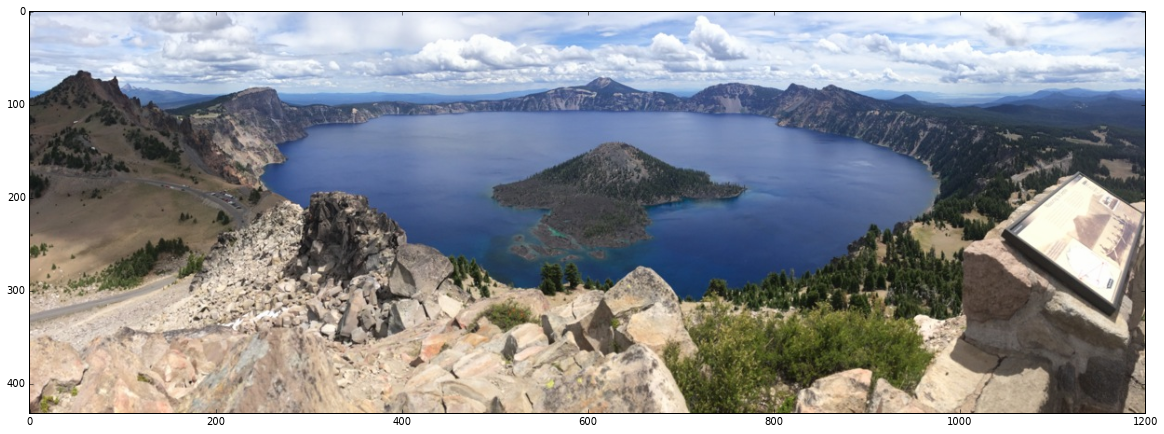

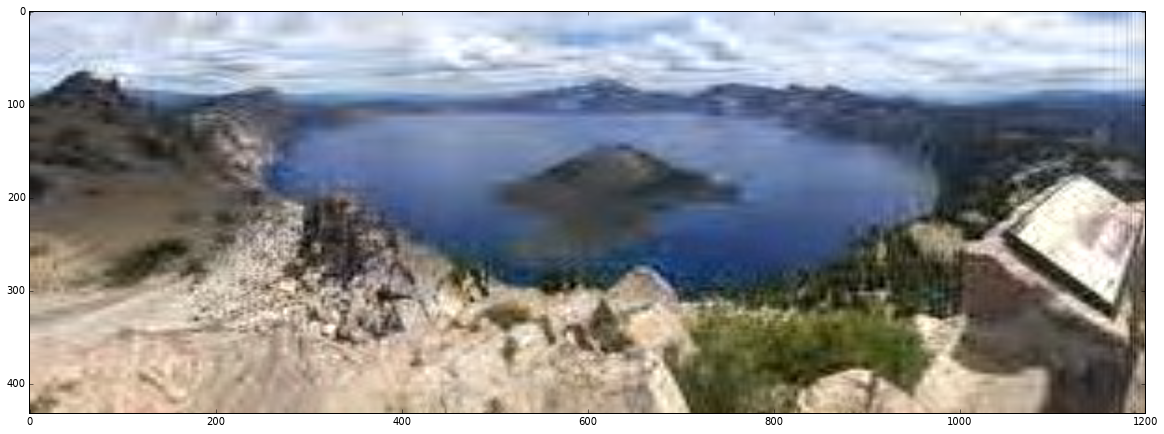

In [7]:
figure(figsize=(20,8))
ims_rgb(im)
figure(figsize=(20,8))
ims_rgb(imm)

In [8]:
ar = np.array(x.tolist())
bit_list = []
for i in xrange(0, len(ar), Nbits_packet_noec):
    b = ar[i:i+Nbits_packet_noec]
    if len(b) < Nbits_packet_noec:
        b = np.append(b, np.zeros(Nbits_packet_noec - len(b)))
    bit_list.append(util.encorrect(b))
    
N_packets = len(bit_list)
N_packets

30

In [9]:
def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name
        
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 HDA NVidia: CS4206 Analog (hw:0,0)
1 HDA NVidia: CS4206 Digital (hw:0,1)
2 HDA NVidia: HDMI 0 (hw:0,3)
3 HDA NVidia: HDMI 0 (hw:0,7)
4 HDA NVidia: HDMI 0 (hw:0,8)
5 USB PnP Sound Device: Audio (hw:1,0)
6 sysdefault
7 front
8 surround21
9 surround40
10 surround51
11 surround71
12 iec958
13 spdif
14 hdmi
15 pulse
16 dmixout
17 dmix
18 default


In [10]:
# CHANGE!!!!
dusb_in = 5
dusb_out = 5
din = 0
dout = 0

In [11]:
if sys.platform == 'darwin':  # Mac
    s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
else:                         #windows
    s = serial.Serial(port='/dev/ttyUSB1') ##### CHANGE !!!!!!
s.setDTR(0)

In [12]:
try:
    sdr = RtlSdr()
except IOError:
    print('defined already')

In [13]:
#sdr.close()

In [14]:
zero_sample = np.zeros(int(44100 * 0.3))

packet = build_packet(bit_list[0])

record_len = int(((len(packet) + between_len) / float(fs))*N_packets) + 3

In [15]:
record_len

71

In [18]:
freq_offset = 83.2e3

sample_rate = 240e3
center_freq = 443.582e6 - freq_offset
#center_freq = 145.442e6 #- freq_offset

sdr.sample_rate = sample_rate  
sdr.center_freq = center_freq   
sdr.gain = 10

In [19]:
# creates a queue
Qout = Queue.Queue()

# initialize a serial port 
s.setDTR(0)
# create a pyaudio object
p = pyaudio.PyAudio()

t_play = threading.Thread(target = play_audio,   args = (Qout,   p, 44100, dusb_out, s ,0.2 ))

#Qout.put(sig2)
Qout.put("KEYON")
Qout.put(zero_sample)

for i in range(N_packets):
    Qout.put(build_packet(bit_list[i]))
    Qout.put(np.zeros(between_len))

Qout.put(np.zeros(1024))
Qout.put("KEYOFF")
Qout.put(zero_sample)
Qout.put("EOT")

# play audio from Queue 
t_play.start()

samples = []

def callback(ss, obj):
    samples.append(ss)
    #obj.cancel_read_async()

N_samples = sample_rate*0.5 # approximately seconds
sdr.read_samples_async(limit_time(record_len)(callback), N_samples)   # get samples

sdr_samples = np.hstack(samples)
    
# must wait for the queue to empty before terminating pyaudio
while not(Qout.empty()) :
    time.sleep(1)
    

p.terminate()# kill a playing thread

In [20]:
#_ = myspectrogram_hann_ovlp(sdr_samples, 2048, sample_rate, center_freq)

In [21]:
ss = smart_demod(sdr_samples, sample_rate, freq_offset)
#del sdr_samples

1


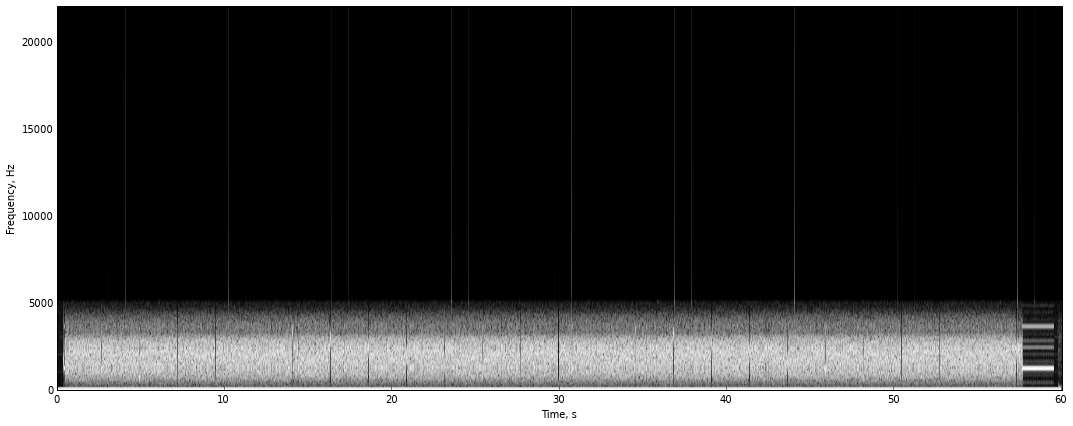

In [18]:
figure()
wsize = 512
dbf = 10
_ = myspectrogram_hann_ovlp(ss[:], wsize, fs, 0, dbf)

In [22]:
import Levenshtein as leven

packets = findPackets(ss)[0]
print(len(packets))

print('errors')
for i in range(len(packets)):
    pp = packets[i]
    decoded = decodePacket(pp)

    ds = ''.join([str(int(x)) for x in decoded])
    bs = ''.join([str(int(x)) for x in bit_list[i]])

    dist = leven.distance(bs, ds)
    print(dist)
#     print(100 * float(dist) / Nbits)
    print(leven.editops(bs, ds)[:10])

30
errors
0
[]
0
[]
0
[]
0
[]
1
[('replace', 0, 0)]
1
[('replace', 0, 0)]
1
[('replace', 0, 0)]
1
[('replace', 0, 0)]
0
[]
0
[]
1
[('replace', 0, 0)]
1
[('replace', 0, 0)]
2
[('replace', 0, 0), ('replace', 4895, 4895)]
0
[]
0
[]
0
[]
1
[('replace', 0, 0)]
1
[('replace', 0, 0)]
0
[]
0
[]
1
[('replace', 0, 0)]
1
[('replace', 0, 0)]
1
[('replace', 0, 0)]
0
[]
0
[]
0
[]
1
[('replace', 0, 0)]
1
[('replace', 0, 0)]
0
[]
0
[]


In [23]:
decodes = map(lambda p: util.correct(decodePacket(p)), packets)

In [24]:
new_x = np.hstack(decodes)
new_x_bits = bitarray.bitarray(new_x.tolist())

In [25]:
len(new_x_bits)

144000

In [26]:
imm2 = decompressanddecode(new_x_bits)

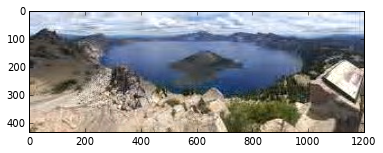

In [27]:
ims(np.clip(imm2, 0, 255)/256.0)

NameError: name 'sdr' is not defined